# Machine Learning- Section4

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sklearn
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import re

In [2]:
rng = np.random.RandomState(20201104)
pd.set_option('display.max_columns', 500)

# Section1: Understand the Dataset

## 1. Read Dataframe

In [4]:
SBA_national= pd.read_csv('SBAnational.csv', low_memory=False)
SBA_national.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,84,4,2.0,0,0,1,0,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,60,2,2.0,0,0,1,0,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,180,7,1.0,0,0,1,0,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,60,2,1.0,0,0,1,0,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,240,14,1.0,7,7,1,0,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [5]:
SBA_national.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
LoanNr_ChkDgt        899164 non-null int64
Name                 899150 non-null object
City                 899134 non-null object
State                899150 non-null object
Zip                  899164 non-null int64
Bank                 897605 non-null object
BankState            897598 non-null object
NAICS                899164 non-null int64
ApprovalDate         899164 non-null object
ApprovalFY           899164 non-null object
Term                 899164 non-null int64
NoEmp                899164 non-null int64
NewExist             899028 non-null float64
CreateJob            899164 non-null int64
RetainedJob          899164 non-null int64
FranchiseCode        899164 non-null int64
UrbanRural           899164 non-null int64
RevLineCr            894636 non-null object
LowDoc               896582 non-null object
ChgOffDate           162699 non-null object
DisbursementDate 

In [6]:
print('Number of Rows of the dataset is: ', SBA_national.shape[0])
print('Number of Columns of the dataset is: ', SBA_national.shape[1])

Number of Rows of the dataset is:  899164
Number of Columns of the dataset is:  27


## 2. Change dtypes of needed columns

### 2.1 Dates

In [7]:
dates_columns=['ApprovalDate','DisbursementDate']
SBA_national['ApprovalDate']= pd.to_datetime(SBA_national['ApprovalDate'], format='%d-%b-%y')
SBA_national['DisbursementDate']= pd.to_datetime(SBA_national['DisbursementDate'], format='%d-%b-%y')

### 2.1 Currency

In [8]:
currency_columns= ['DisbursementGross','SBA_Appv', 'GrAppv', 'BalanceGross',  'ChgOffPrinGr']
SBA_national["DisbursementGross"]=SBA_national["DisbursementGross"].apply(lambda x: float(x.split(",")[0].split("$")[1]))
SBA_national["SBA_Appv"]=SBA_national.SBA_Appv.apply(lambda x: float(x.split(",")[0].split("$")[1]))
SBA_national["GrAppv"]=SBA_national.GrAppv.apply(lambda x: float(x.split(",")[0].split("$")[1]))

## 3. Data Preprocessing 
We do this column-wise

## 3.1 MIS_Status
We have 1997 null values here, we fill them with the help og the 'ChgOffPrinGr' columns as it has the a value of the reminder of loan not paid by business hence it is charged off!

In [9]:
SBA_national.loc[(SBA_national['MIS_Status'].isnull()) , 'MIS_Status']= SBA_national[(SBA_national['MIS_Status'].isnull())]['ChgOffPrinGr']
SBA_national['Y']= SBA_national['MIS_Status']
SBA_national['Y'].replace({'P I F': 1,'$0.00 ':1}, inplace= True)
SBA_national.loc[SBA_national['Y']!=1 , 'Y'] = 0
SBA_national.drop(columns=['MIS_Status'], inplace= True)
SBA_national['Y'].dropna(inplace=True)
len(SBA_national)

899164

In [10]:
SBA_national['Y'].value_counts()

1    741349
0    157815
Name: Y, dtype: int64

### 3.2 State
We fill the 14 null from this column with the help of the 'City', there are 2 values OUTSIDE the US so we remove them 

In [11]:
#Filled Manually!
SBA_national.loc[35517, 'State'] = 'NJ'
SBA_national.loc[49244, 'State'] = 'NY'
SBA_national.loc[264664, 'State'] = 'TX'
SBA_national.loc[306274, 'State'] = 'AP'
SBA_national.loc[328526, 'State'] = 'KS'
SBA_national.loc[366139, 'State'] = 'FL'
SBA_national.loc[366158, 'State'] = 'ME'
SBA_national.loc[379174, 'State'] = 'UT'
SBA_national.loc[385418, 'State'] = 'MO'
SBA_national.loc[869948, 'State'] = 'TX'
SBA_national.loc[871847, 'State'] = 'TX'
SBA_national.loc[885335, 'State'] = 'TX'
SBA_national= SBA_national.loc[SBA_national['State'].notna(), :]
print('Then the dataframe gets reduced by 2, which is acceplaple as the df is large')
print('The new Datarfame is: ', len(SBA_national))

Then the dataframe gets reduced by 2, which is acceplaple as the df is large
The new Datarfame is:  899162


### 3.3 NAICS
No Nulls here, just extract the 53 code.

In [12]:
SBA_national.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,Y
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997-02-28,1997,84,4,2.0,0,0,1,0,N,Y,NaN,1999-02-28,60.0,$0.00,$0.00,60.0,48.0,1
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,1997-02-28,1997,60,2,2.0,0,0,1,0,N,Y,NaN,1997-05-31,40.0,$0.00,$0.00,40.0,32.0,1
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,1997-02-28,1997,180,7,1.0,0,0,1,0,N,N,NaN,1997-12-31,287.0,$0.00,$0.00,287.0,215.0,1
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,1997-02-28,1997,60,2,1.0,0,0,1,0,N,Y,NaN,1997-06-30,35.0,$0.00,$0.00,35.0,28.0,1
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,1997-02-28,1997,240,14,1.0,7,7,1,0,N,N,NaN,1997-05-14,229.0,$0.00,$0.00,229.0,229.0,1


In [13]:
SBA_national["is53"]=SBA_national['NAICS'].apply(lambda x: 1 if str(x).startswith("53") else 0)
SBA_national.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,Y,is53
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997-02-28,1997,84,4,2.0,0,0,1,0,N,Y,NaN,1999-02-28,60.0,$0.00,$0.00,60.0,48.0,1,0


### 3.4 Term
This feature has no nulls, and refering to the Paper we need to distinguish the realestate businesses as they have much higher loans months.

In [14]:
SBA_national["isRealEstate"]=SBA_national.Term.apply(lambda x: 1 if x>=240 else 0)
SBA_national.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,Y,is53,isRealEstate
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997-02-28,1997,84,4,2.0,0,0,1,0,N,Y,NaN,1999-02-28,60.0,$0.00,$0.00,60.0,48.0,1,0,0


### 3.5 NoEmp, CreateJob, RetainedJob
All three has no null values, Since they mean the same thing Can we combine them together?

#### 3.5.1 NoEmp
No Null values 

#### 3.5.2 CreateJob
No Null values 

#### 3.5.3 RetainedJob
No Null values 

#### 3.5.4 Combine Those Columns

In [15]:
# lets add those to eachother
# Plot first!!!
SBA_national['sizeOfBusiness']= SBA_national['RetainedJob'] +SBA_national['CreateJob']+SBA_national['NoEmp']

### 3.6 FranchiseCode
No Null Values! According to the Paper, Values 0 or 1 means Not a Franchise, else is a Franchise.

In [16]:
SBA_national['isFranchise']= SBA_national['FranchiseCode'].replace({1: 0})
SBA_national.loc[SBA_national['isFranchise']!=0, 'isFranchise'] =1

In [17]:
SBA_national['isFranchise'].value_counts()

0    847387
1     51775
Name: isFranchise, dtype: int64

### 3.7 NewExist
This has missing values of 136 which not considered a large number compared to the dataset but can be infered from the isFranchise Column as normally Franchises do Exist for around than 2 years! (Assumption).
We Turn the data into another column (more readable) and the values to be 1 exist or 0 new business.

In [18]:
SBA_national['isExist']= SBA_national['NewExist']
SBA_national["isExist"].fillna(SBA_national["isFranchise"], inplace=True)
SBA_national['isExist'].replace({2: 0}, inplace = True)
SBA_national['isExist'].value_counts()

1.0    644875
0.0    254287
Name: isExist, dtype: int64

### 3.8 Urban/Rural
Has no Nulls! But htis column has Noise of undefined data of 323167 which is 36% of the data a rather large portion, so we remove this column from our analysis as we cannot infere it from other values safely and cannot drop the nulls!

In [19]:
SBA_national['UrbanRural'].value_counts()

1    470654
0    323165
2    105343
Name: UrbanRural, dtype: int64

### 3.9 RevLineCr
This column has 4528 and we don't need it anyways so we drop it!

In [20]:
len(SBA_national[(SBA_national['RevLineCr'].isnull())])

4528

In [21]:
SBA_national['RevLineCr'].value_counts()

N    420286
0    257602
Y    201397
T     15284
1        23
R        14
`        11
2         6
C         2
A         1
-         1
.         1
Q         1
5         1
4         1
,         1
7         1
3         1
Name: RevLineCr, dtype: int64

### 3.10 LowDoc
There are Null values of 2582 which is not large portion of the dataset but can be infered from 'GrAppv' column which has the loan amound (divided by 1000) so if it is >150 then it is 0 in the LowDoc and else is 1

In [22]:
SBA_national["LowDoc"].replace({'0': None , '1': None, 'A': None, 'C': None, 'R': None, 'S': None}, inplace= True)
SBA_national['isLowDoc']=SBA_national['GrAppv']> 150 
SBA_national["LowDoc"].fillna(SBA_national["isLowDoc"], inplace=True)
SBA_national["LowDoc"].replace({'N':0, False: 0,  'Y':1, True:1 }, inplace = True)

In [23]:
SBA_national["LowDoc"].value_counts()

0    786730
1    112432
Name: LowDoc, dtype: int64

### 3.11 Date Columns DisbursementDate and Term
DisbursementDate Has 2368 null values, small portion we can infere them from the 'ApprovalDate' it will not be quiet accurate for further data manipulation so we choose to drop them 

#### 3.11.1 Drop the Null Values

In [24]:
SBA_national= SBA_national.loc[SBA_national['DisbursementDate'].notna(), :]
len(SBA_national)

896794

In [25]:
SBA_national

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,Y,is53,isRealEstate,sizeOfBusiness,isFranchise,isExist,isLowDoc
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997-02-28,1997,84,4,2.0,0,0,1,0,N,1,NaN,1999-02-28,60.0,$0.00,$0.00,60.0,48.0,1,0,0,4,0,0.0,False
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,1997-02-28,1997,60,2,2.0,0,0,1,0,N,1,NaN,1997-05-31,40.0,$0.00,$0.00,40.0,32.0,1,0,0,2,0,0.0,False
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,1997-02-28,1997,180,7,1.0,0,0,1,0,N,0,NaN,1997-12-31,287.0,$0.00,$0.00,287.0,215.0,1,0,0,7,0,1.0,True
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,1997-02-28,1997,60,2,1.0,0,0,1,0,N,1,NaN,1997-06-30,35.0,$0.00,$0.00,35.0,28.0,1,0,0,2,0,1.0,False
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,1997-02-28,1997,240,14,1.0,7,7,1,0,N,0,NaN,1997-05-14,229.0,$0.00,$0.00,229.0,229.0,1,0,1,28,0,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,1997-02-27,1997,60,6,1.0,0,0,1,0,0,0,NaN,1997-09-30,70.0,$0.00,$0.00,70.0,56.0,1,0,0,6,0,1.0,False
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,1997-02-27,1997,60,6,1.0,0,0,1,0,Y,0,NaN,1997-10-31,85.0,$0.00,$0.00,85.0,42.0,1,0,0,6,0,1.0,False
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,1997-02-27,1997,108,26,1.0,0,0,1,0,N,0,NaN,1997-09-30,300.0,$0.00,$0.00,300.0,225.0,1,0,0,26,0,1.0,True
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,1997-02-27,1997,60,6,1.0,0,0,1,0,N,1,8-Mar-00,1997-03-31,75.0,$0.00,"$46,383.00",75.0,60.0,0,0,0,6,0,1.0,False


#### 3.11.2 Create The isDueInGreatRecession
Multiply the Term in Month by avg 30 days and add it to the DisbursementDate and check if this date resides between the great recession time or not.

In [26]:
SBA_national['TerminDays']= SBA_national['Term']* 30
SBA_national['TerminDays']= pd.to_timedelta(SBA_national['TerminDays'], unit= 'D')
SBA_national['LoanEndDate']= SBA_national['TerminDays']+ SBA_national['DisbursementDate']
#set the boundries of the great recession
min_date= pd.to_datetime('2007-12-01')
max_date= pd.to_datetime('2009-06-30')
SBA_national['isDueInGreatRecession']= SBA_national['LoanEndDate'].apply(lambda x: 1 if ((x >= min_date) & (x<=max_date)) else 0)

In [27]:
SBA_national['isDueInGreatRecession'].value_counts()

0    825239
1     71555
Name: isDueInGreatRecession, dtype: int64

### 3.12 Loan amount Columns ('SBA_Appv','GrAppv')
Don't have nulls, and can be used to get the percentage of the load paid by SBA as this assumed to be a safe factor for banks

In [28]:
SBA_national["SBA_portion"]=SBA_national["SBA_Appv"]/SBA_national["GrAppv"]
SBA_national.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,Y,is53,isRealEstate,sizeOfBusiness,isFranchise,isExist,isLowDoc,TerminDays,LoanEndDate,isDueInGreatRecession,SBA_portion
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997-02-28,1997,84,4,2.0,0,0,1,0,N,1,NaN,1999-02-28,60.0,$0.00,$0.00,60.0,48.0,1,0,0,4,0,0.0,False,2520 days,2006-01-22,0,0.8


## 4. Drop some columns

In [29]:
drop_columns= ['LoanNr_ChkDgt', 'Name', 'City','Zip', 
               'Bank','ApprovalDate', 'ApprovalFY', 'CreateJob',
               'RetainedJob', 'FranchiseCode', 'RevLineCr', 
               'ChgOffDate', 'DisbursementDate', 'BalanceGross',
               'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
              'NewExist','UrbanRural', 'DisbursementGross',
               'TerminDays','LoanEndDate', 'NAICS', 'isLowDoc','BankState']
SBA_national_final= SBA_national.drop(columns= drop_columns)
SBA_national_final.head()

,State,Term,NoEmp,LowDoc,Y,is53,isRealEstate,sizeOfBusiness,isFranchise,isExist,isDueInGreatRecession,SBA_portion
0,IN,84,4,1,1,0,0,4,0,0.0,0,0.800000
1,IN,60,2,1,1,0,0,2,0,0.0,0,0.800000
2,IN,180,7,0,1,0,0,7,0,1.0,0,0.749129
3,OK,60,2,1,1,0,0,2,0,1.0,0,0.800000
4,FL,240,14,0,1,0,1,28,0,1.0,0,1.000000


# Demo about Categorical Data Encoding

### Categorical Data Encoding!
Dummy Encoder:
    State-> No change 
    (IN->0 , OK->1, FL->2)
    0
    0
    0
    1
    2
Onehotencoder!
IN, OK, FL -> 1 ,2 ,3 
State -> IN , OK, FL
         1    0   0
         1    0   0
         1    0   0 
         0    1   0

In [ ]:
# End Demo

In [30]:
SBA_national_final.columns

Index(['State', 'Term', 'NoEmp', 'LowDoc', 'Y', 'is53', 'isRealEstate',
       'sizeOfBusiness', 'isFranchise', 'isExist', 'isDueInGreatRecession',
       'SBA_portion'],
      dtype='object')

In [31]:
# Reorder the df to be ready 
new_arrangement= ['State', 'Term', 'NoEmp', 'LowDoc',  'is53', 'isRealEstate',
       'sizeOfBusiness', 'isFranchise', 'isExist', 'isDueInGreatRecession',
       'SBA_portion','Y']
SBA_national_final=SBA_national_final[new_arrangement]
SBA_national_final.head()

,State,Term,NoEmp,LowDoc,is53,isRealEstate,sizeOfBusiness,isFranchise,isExist,isDueInGreatRecession,SBA_portion,Y
0,IN,84,4,1,0,0,4,0,0.0,0,0.800000,1
1,IN,60,2,1,0,0,2,0,0.0,0,0.800000,1
2,IN,180,7,0,0,0,7,0,1.0,0,0.749129,1
3,OK,60,2,1,0,0,2,0,1.0,0,0.800000,1
4,FL,240,14,0,0,1,28,0,1.0,0,1.000000,1


# Demo about min model accuracy?

**What is sufficient Accuracy:**

1- Case1:

Y:

    1-> 80
    
    0->20
    
**Model Accuracy > 80%**

2- Case2:

Y:

    1-> 50
    
    0->50
    
**Model Accuracy > 50%**

In [42]:
SBA_national_final.groupby(['isRealEstate'])['SBA_portion'].count()

isRealEstate
0    744706
1    152088
Name: SBA_portion, dtype: int64

In [43]:
new_df= SBA_national_final.groupby(['isRealEstate','Y'])['SBA_portion'].count().reset_index()
new_df

,isRealEstate,Y,SBA_portion
0,0,0,154944
1,0,1,589762
2,1,0,2470
3,1,1,149618


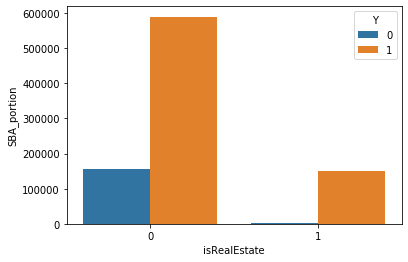

In [44]:
sns.barplot(data =new_df, x= 'isRealEstate', y= 'SBA_portion', hue= 'Y')

# End Demo

In [45]:
SBA_national_final.columns

Index(['State', 'Term', 'NoEmp', 'LowDoc', 'is53', 'isRealEstate',
       'sizeOfBusiness', 'isFranchise', 'isExist', 'isDueInGreatRecession',
       'SBA_portion', 'Y'],
      dtype='object')

# Section2: Fulfill The Requirements

## 1. Data Prep and Exploration (20%)

**1. Load the data and do your initial preparation. How many observations and variables do you have?**

Note That: Now we use the data after processing not Initial Data


In [46]:
loans= SBA_national_final.copy()

In [47]:
print('Number of Rows of the dataset is: ', loans.shape[0])
print('Number of Columns of the dataset is: ', loans.shape[1])

Number of Rows of the dataset is:  896794
Number of Columns of the dataset is:  12


**2. Select a 25% sample of the data for use in testing.**

We divide the Data into Train and Test with 75% - 25% respictively, (The Train Data is Further divided into fake_train and fake_test -> For Tuning data)

In [48]:
# Train test split
test = loans.sample(frac=0.25,random_state=rng)
train_mask = pd.Series(True, index=loans.index)
train_mask[test.index] = False
train = loans[train_mask].copy()
# Make Tuning Train Test (Fake Train/test)
fake_test = train.sample(frac=0.2, random_state=rng)
fake_train_mask = pd.Series(True, index=train.index)
fake_train_mask[fake_test.index] = False
fake_train = train[fake_train_mask].copy()
# X and Y columns
train_x = train.iloc[:, :-1]
train_y = train.iloc[:, -1]
test_x = test.iloc[:, :-1]
test_y = test.iloc[:, -1]

Train /Test
Train(train/ tune) / Test
model(train) -> model(tune) - did I like the performance?
model(Train) -> Test  - did I like the performance? Go ahead 
Repeat!


**3. Describe the distribution of the outcome variable. What is the majority class?**


In [50]:
train_y.value_counts()

1    554837
0    117759
Name: Y, dtype: int64

The data has 554837 of 1s and 117759 of 0s, Thus the majority is the 1s.

**4. What is the accuracy, precision, and recall of the majority-class classifier on the test data?**


In [51]:
majority_classifier_predict= [1 for i in range (0, len(test_y))]
tn, fp, fn, tp = confusion_matrix(test_y, majority_classifier_predict).ravel()
accuracy= (tp+tn)/(tp+tn+fp+fn)
percision= tp/(tp+fp)
recal= tp/(tp+fn)
specificity = tn / (tn+fp)
print('Accuracy for this Model is : ', accuracy)
print('Percision for this Model is : ', percision)
print('Recal for this Model is : ', recal)
print('Specificity for this Model is : ', specificity)

Accuracy for this Model is :  0.8231250947822907
Percision for this Model is :  0.8231250947822907
Recal for this Model is :  1.0
Specificity for this Model is :  0.0


**5. Identify some variables that, based on your understanding and reading (e.g. the source paper!) are likely to be useful for predicting default. Describe them, your motivation, their distribution, and their relationship to outcomes (in the training data). Do feature transformations you Ønd useful here as well. You may need to create interaction features, or do other feature transformations.**

So, This is illustrated more on The Section1 of this notebook and this is an extenson to it. We used those features as they are morelikely to be good predictors according to our own opinions and influnced by the paper, The features are:
['State', 'Term', 'NoEmp', 'LowDoc', 'is53', 'isRealEstate', 'sizeOfBusiness', 'isFranchise', 'isExist', 'isDueInGreatRecession','SBA_portion', 'Y']

Some explanations:
1. The State variable to see it there is a relation between states and output and to do the next part of the assignement along with the 'is53' column.
2. Those features are influnced by the reading ['isRealEstate', 'isExist', 'isDueInGreatRecession','SBA_portion' ], all of them are drived from the original dataset and 'isExist' is filled its nulls by the help of the 'isFranchise' as we though if a business is a ranchise then it is not new!
3. The 'sizeOfBusiness' feature here is a sum of the NoEmp, CreateJob, RetainedJob as they mean the size of employees!



## 2. Subset Model (15%)


In [52]:
# Make Tuning Train Test (Train/tune)
# Take the Original Train/ Test and subset them with conditions
# Split the trainSubset into subsetTrain / subsetTune
#Try different features -> get best one
# Apply on testSubset
trainSubset=train.loc[(train["State"]=="CA")&(train["is53"]== 1), :]
testSubset=test.loc[(test["State"]=="CA")&(test["is53"]==1), :]

subsetTune = trainSubset.sample(frac=0.2)
subsetTrain_mask = pd.Series(True, index=trainSubset.index)
subsetTrain_mask[subsetTune.index] = False
subsetTrain = trainSubset[subsetTrain_mask].copy()

### 2.1 First set of features

In [55]:
# Set the features/ output colun/ Model
subset_features1= ['is53','isExist', 'isDueInGreatRecession', 'SBA_portion', 'isFranchise']
out_col= ['Y']
lg_subset=LogisticRegression()
#Make x,y splits on Train data
trainSubset_x = subsetTrain[subset_features1]
trainSubset_y = subsetTrain[out_col]
#Now on Tune Data
tuneSubset_x = subsetTune[subset_features1]
tuneSubset_y = subsetTune[out_col]
#Fit the model and predict on Tune data
lg_subset.fit(trainSubset_x, trainSubset_y)
predicted_output = lg_subset.predict(tuneSubset_x)
#Calculate accuracy
print('Accuracy of Model on The Training Data : ', np.mean(tuneSubset_y))
print('Accuracy of Model on Tuning Data: ',accuracy_score(tuneSubset_y, predicted_output))

Accuracy of Model on The Training Data :  Y    0.643312
dtype: float64
Accuracy of Model on Tuning Data:  0.6560509554140127


C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [56]:
# Set the features/ output colun/ Model
subset_features1= ['is53','isExist',  'SBA_portion', 'isFranchise']
out_col= ['Y']
lg_subset=LogisticRegression()
#Make x,y splits on Train data
trainSubset_x = subsetTrain[subset_features1]
trainSubset_y = subsetTrain[out_col]
#Now on Tune Data
tuneSubset_x = subsetTune[subset_features1]
tuneSubset_y = subsetTune[out_col]
#Fit the model and predict on Tune data
lg_subset.fit(trainSubset_x, trainSubset_y)
predicted_output = lg_subset.predict(tuneSubset_x)
#Calculate accuracy
print('Accuracy of Model on The Training Data : ', np.mean(tuneSubset_y))
print('Accuracy of Model on Tuning Data: ',accuracy_score(tuneSubset_y, predicted_output))

Accuracy of Model on The Training Data :  Y    0.643312
dtype: float64
Accuracy of Model on Tuning Data:  0.6305732484076433


C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train (train - Tune data ) --> model(train) -> prediction= model(tune)
prediction = 0.710
actual - tune[y] = num of 1's / (num of 1' + num 0's) = 0.719
majority class classifier = 100% 


**This means we are doing a better accuracy with this model than the majority class classifier which has accuracy of 67% **

### 2.2 Second set of features

In [39]:
# Set the features/ output column/ Model
subset_features2= ['is53','isExist', 'isDueInGreatRecession', 'SBA_portion', 'sizeOfBusiness']
out_col= ['Y']
lg_subset2=LogisticRegression()
#Make x,y splits on Train data
trainSubset_x = subsetTrain[subset_features2]
trainSubset_y = subsetTrain[out_col]
#Now on Tune Data
tuneSubset_x = subsetTune[subset_features2]
tuneSubset_y = subsetTune[out_col]
#Fit the model and predict on Tune data
lg_subset2.fit(trainSubset_x, trainSubset_y)
predicted_output = lg_subset2.predict(tuneSubset_x)
#Calculate accuracy
print('Accuracy of Model on The Training Data : ', np.mean(tuneSubset_y))
print('Accuracy of Model on Tuning Data: ',accuracy_score(tuneSubset_y, predicted_output))

Accuracy of Model on The Training Data :  Y    0.719745
dtype: float64
Accuracy of Model on Tuning Data:  0.7006369426751592


C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Comparing the accuracy from the 2 models the first one is doing better, so we pick it as our Final model to apply on test data and see its results**

### 2.3 Final Subset Model 

In [40]:
trainSubset=train.loc[(train["State"]=="CA")&(train["is53"]== 1), :]
testSubset=test.loc[(test["State"]=="CA")&(test["is53"]==1), :]

In [41]:
# Set the features/ output colun/ Model
final_subset_features= subset_features1
out_col= ['Y']
finalModel1=LogisticRegression()
#Make x,y splits on Train data
trainSubset_x = trainSubset[subset_features2]
trainSubset_y = trainSubset[out_col]
#Now on Tune Data
testSubset_x = testSubset[subset_features2]
testSubset_y = testSubset[out_col]
#Fit the model and predict on Tune data
finalModel1.fit(trainSubset_x, trainSubset_y)
predicted_output = finalModel1.predict(testSubset_x)
#Calculate accuracy
print('Accuracy of Model on The Training Data : ', np.mean(testSubset_y))
print('Accuracy of Model on Testing Data: ',accuracy_score(testSubset_y, predicted_output))

Accuracy of Model on The Training Data :  Y    0.689046
dtype: float64
Accuracy of Model on Testing Data:  0.6855123674911661


C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**The model is making less accuracy than the majority class classifier for the test data even that it was doing better on the tune data, Which is Not good!!**

# Added Section - Extra Work


## 3. Full Model (20%)

In [42]:
### First make a Train/Tune Data for the Full dataset

In [43]:
# Make Tuning Train  (Fake Train/test)
fake_test = train.sample(frac=0.2, random_state=rng)
fake_train_mask = pd.Series(True, index=train.index)
fake_train_mask[fake_test.index] = False
fake_train = train[fake_train_mask].copy()

### 3.1 Using the Model from the Subset model on Test Data

In [44]:
# Set the features/ output colun/ Model
final_subset_features= subset_features1
out_col= ['Y']
finalModel1=LogisticRegression()
#Make x,y splits on Train data
train_x = fake_train[final_subset_features]
train_y = fake_train[out_col]
#Now on Tune Data
test_x = fake_test[final_subset_features]
test_y = fake_test[out_col]
#Fit the model and predict on Tune data
finalModel1.fit(train_x, train_y)
predicted_output = finalModel1.predict(test_x)
#Calculate accuracy
print('Accuracy of Model on The Training Data : ', np.mean(test_y))
print('Accuracy of Model on Testing Data: ',accuracy_score(test_y, predicted_output))

C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Model on The Training Data :  Y    0.825824
dtype: float64
Accuracy of Model on Testing Data:  0.8258238613132717


**The model from the subset model is doing slightly below the majority class classifier**

### 3.2 Use Another Model ( Other Features as State as Onehotencoder)
So here we use the States column and Standrizing the sizeOfBusiness and SBA_portion columns

In [45]:
# Set the features/ output colun/ Model
all_features = ['State', 'LowDoc', 'is53', 'isRealEstate',
       'sizeOfBusiness', 'isFranchise', 'isExist', 'isDueInGreatRecession',
       'SBA_portion',]
full_model_features2= all_features
out_col= ['Y']
finalModel1=LogisticRegression()
#Make x,y splits on Train data
train_x = fake_train[full_model_features2]
train_y = fake_train[out_col]
#Now on Tune Data
tune_x = fake_test[full_model_features2]
tune_y = fake_test[out_col]

In [46]:
column_trans = ColumnTransformer(
   [('dummyCode', OneHotEncoder(dtype='int'),["State"]),
     ('standardize', StandardScaler(), ['SBA_portion', 'sizeOfBusiness'])],
     remainder='passthrough')
column_trans.fit(train_x)
# Transform features of Tune and Train values
train_transformed= column_trans.transform(train_x)
test_transformed= column_trans.transform(tune_x)

finalModel1=LogisticRegression()
finalModel1.fit(train_transformed, train_y)
predicted_output = finalModel1.predict(test_transformed)
#Calculate accuracy
print('Accuracy of Model on The Training Data : ', np.mean(tune_y))
print('Accuracy of Model on Tuning Data: ',accuracy_score(tune_y, predicted_output))

C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Model on The Training Data :  Y    0.825824
dtype: float64
Accuracy of Model on Tuning Data:  0.826076613712561


**This model is doing slightly better than the one form subset model so we pick this one to test on the test data**

### 3.2 Choose the best model (based on accuracy) and test it on test data

In [47]:
# Set the features/ output colun/ Model
all_features = ['State', 'LowDoc', 'is53', 'isRealEstate',
       'sizeOfBusiness', 'isFranchise', 'isExist', 'isDueInGreatRecession',
       'SBA_portion',]
full_model_features2= all_features
out_col= ['Y']
finalModel1=LogisticRegression()
#Make x,y splits on Train/Test data
train_x = train[full_model_features2]
train_y = train[out_col]
#Now on Tune Data
test_x = test[full_model_features2]
test_y = test[out_col]

In [48]:
column_trans = ColumnTransformer(
   [('Encoding', OneHotEncoder(dtype='int'),["State"]),
     ('standardize', StandardScaler(), ['SBA_portion', 'sizeOfBusiness'])],
     remainder='passthrough')
column_trans.fit(train_x)
# Transform features of Tune and Train values
train_transformed= column_trans.transform(train_x)
test_transformed= column_trans.transform(test_x)

finalModel1=LogisticRegression()
finalModel1.fit(train_transformed, train_y)
predicted_output1 = finalModel1.predict(test_transformed)
#Calculate accuracy
print('Accuracy of Model on The Training Data : ', np.mean(test_y))
print('Accuracy of Model on Tuning Data: ',accuracy_score(test_y, predicted_output1))

C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Model on The Training Data :  Y    0.823125
dtype: float64
Accuracy of Model on Tuning Data:  0.8234060963969349


**It is doing slightly better than the majority class classifier, so ok!**

## 4. Lasso Regression (15%)

In [49]:
# Set the features/ output colun/ Model
all_features = [ 'LowDoc', 'is53', 'isExist', 'isDueInGreatRecession',
       'SBA_portion',]
full_model_features2= all_features
out_col= ['Y']
finalModel1=LogisticRegression()
#Make x,y splits on Train/Test data
train_x = train[full_model_features2]
train_y = train[out_col]
#Now on Tune Data
test_x = test[full_model_features2]
test_y = test[out_col]

#Use Transformer for columns
column_trans = ColumnTransformer(
   [#('dummyCode', OneHotEncoder(dtype='int'),["State"]),
     ('standardize', StandardScaler(), ['SBA_portion'])],
     remainder='passthrough')
column_trans.fit(train_x)
# Transform features of Tune and Train values
train_transformed= column_trans.transform(train_x)
test_transformed= column_trans.transform(test_x)


In [50]:
# Fit 
lasso_pipe = Pipeline([
    ('classify', LogisticRegressionCV(penalty='l1', solver='saga'))
])
lasso_pipe.fit(train_transformed, train_y)
predicted_output2 = lasso_pipe.predict(test_transformed)
#Test on Tuning Data
print('Accuracy of Model on Testing Data: ',accuracy_score(test_y, predicted_output2))

C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy of Model on Testing Data:  0.8231250947822907


## 4. Elasticnets (15%)

In [51]:
# Set the features/ output colun/ Model
all_features = [ 'LowDoc', 'is53', 'isExist', 'isDueInGreatRecession',
       'SBA_portion',]
full_model_features2= all_features
out_col= ['Y']
finalModel1=LogisticRegression()
#Make x,y splits on Train/Test data
train_x = train[full_model_features2]
train_y = train[out_col]
#Now on Tune Data
test_x = test[full_model_features2]
test_y = test[out_col]

#Use Transformer for columns
column_trans = ColumnTransformer(
   [#('dummyCode', OneHotEncoder(dtype='int'),["State"]),
     ('standardize', StandardScaler(), ['SBA_portion'])],
     remainder='passthrough')
column_trans.fit(train_x)
# Transform features of Tune and Train values
train_transformed= column_trans.transform(train_x)
test_transformed= column_trans.transform(test_x)


In [52]:
elasticnet_pipe = Pipeline([
    ('classify', LogisticRegressionCV(penalty='elasticnet', solver='saga', l1_ratios=np.linspace(0, 1, 5)))
])

elasticnet_pipe.fit(train_transformed, train_y)
predicted_output3 = elasticnet_pipe.predict(test_transformed)
#Test on Tuning Data
print('Accuracy of Model on Testing Data: ',accuracy_score(test_y, predicted_output3))

C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy of Model on Testing Data:  0.8231250947822907


## 5. Random Forest (10%)

In [53]:
# Set the features/ output colun/ Model
all_features = ['LowDoc', 'is53', 'isExist', 'isDueInGreatRecession',
       'SBA_portion',]
full_model_features2= all_features
out_col= ['Y']
finalModel1=LogisticRegression()
#Make x,y splits on Train/Test data
train_x = train[full_model_features2]
train_y = train[out_col]
#Now on Tune Data
test_x = test[full_model_features2]
test_y = test[out_col]

#Use Transformer for columns
column_trans = ColumnTransformer(
   [#('dummyCode', OneHotEncoder(dtype='int'),["State"]),
     ('standardize', StandardScaler(), ['SBA_portion'])],
     remainder='passthrough')
column_trans.fit(train_x)
# Transform features of Tune and Train values
train_transformed= column_trans.transform(train_x)
test_transformed= column_trans.transform(test_x)


In [54]:
randomForrest_pipe = Pipeline([
    ('classify', RandomForestClassifier(n_estimators=100, criterion= 'entropy', max_depth=None ))
])
randomForrest_pipe.fit(train_transformed, train_y)
predicted_output4 = randomForrest_pipe.predict(test_transformed)
#Test on Tuning Data
print('Accuracy of Model on Testing Data: ',accuracy_score(test_y, predicted_output4))

C:\Users\YOUSRA\Anaconda3\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Accuracy of Model on Testing Data:  0.8232678257611575


# End of Added Section - Extra Work

## 6. Final Summary (10%)

### 6.1 Calculate metrics for all 4 models

In [55]:
accuracy_arr= []
percision_arr= []
recal_arr= []
specificity_arr = []
cost_arr=[]
model_names=['Model1', 'Lasso', 'Elasticnet', 'RandomForrest']

#### 6.1.1 Model1

In [56]:
tn, fp, fn, tp = confusion_matrix(test_y, predicted_output1).ravel()
accuracy= (tp+tn)/(tp+tn+fp+fn)
percision= tp/(tp+fp)
recal= tp/(tp+fn)
specificity = tn / (tn+fp)
accuracy_arr.append(accuracy)
percision_arr.append(percision)
recal_arr.append(recal)
specificity_arr.append(specificity)
model_cost= fn*5 + fp
cost_arr.append(model_cost)
print('Accuracy for this Model is : ', accuracy)
print('Percision for this Model is : ', percision)
print('Recal for this Model is : ', recal)
print('Specificity for this Model is : ', specificity)
print('Cost for this Model is : ', model_cost)

Accuracy for this Model is :  0.8234060963969349
Percision for this Model is :  0.8237638092855579
Recal for this Model is :  0.9992359504288973
Specificity for this Model is :  0.0051443701929138825
Cost for this Model is :  40156


#### 6.1.2 Model2 (Lasso)

In [57]:
tn, fp, fn, tp = confusion_matrix(test_y, predicted_output2).ravel()
accuracy= (tp+tn)/(tp+tn+fp+fn)
percision= tp/(tp+fp)
recal= tp/(tp+fn)
specificity = tn / (tn+fp)
accuracy_arr.append(accuracy)
percision_arr.append(percision)
recal_arr.append(recal)
specificity_arr.append(specificity)
model_cost= fn*5 + fp
cost_arr.append(model_cost)
print('Accuracy for this Model is : ', accuracy)
print('Percision for this Model is : ', percision)
print('Recal for this Model is : ', recal)
print('Specificity for this Model is : ', specificity)
print('Cost for this Model is : ', model_cost)

Accuracy for this Model is :  0.8231250947822907
Percision for this Model is :  0.8231250947822907
Recal for this Model is :  1.0
Specificity for this Model is :  0.0
Cost for this Model is :  39655


#### 6.1.3 Model3 (Elasticnet)

In [58]:
tn, fp, fn, tp = confusion_matrix(test_y, predicted_output3).ravel()
accuracy= (tp+tn)/(tp+tn+fp+fn)
percision= tp/(tp+fp)
recal= tp/(tp+fn)
specificity = tn / (tn+fp)
accuracy_arr.append(accuracy)
percision_arr.append(percision)
recal_arr.append(recal)
specificity_arr.append(specificity)
model_cost= fn*5 + fp
cost_arr.append(model_cost)
print('Accuracy for this Model is : ', accuracy)
print('Percision for this Model is : ', percision)
print('Recal for this Model is : ', recal)
print('Specificity for this Model is : ', specificity)
print('Cost for this Model is : ', model_cost)

Accuracy for this Model is :  0.8231250947822907
Percision for this Model is :  0.8231250947822907
Recal for this Model is :  1.0
Specificity for this Model is :  0.0
Cost for this Model is :  39655


#### 6.1.4 Model4 (RandomForest)

In [59]:
tn, fp, fn, tp = confusion_matrix(test_y, predicted_output4).ravel()
accuracy= (tp+tn)/(tp+tn+fp+fn)
percision= tp/(tp+fp)
recal= tp/(tp+fn)
specificity = tn / (tn+fp)
accuracy_arr.append(accuracy)
percision_arr.append(percision)
recal_arr.append(recal)
specificity_arr.append(specificity)
model_cost= fn*5 + fp
cost_arr.append(model_cost)
print('Accuracy for this Model is : ', accuracy)
print('Percision for this Model is : ', percision)
print('Recal for this Model is : ', recal)
print('Specificity for this Model is : ', specificity)
print('Cost for this Model is : ', model_cost)

Accuracy for this Model is :  0.8232678257611575
Percision for this Model is :  0.8265935294276726
Recal for this Model is :  0.9937683900229215
Specificity for this Model is :  0.029807086117765728
Cost for this Model is :  44223


### 6.2 Plot the metrics for all 4 models

#### 6.2.1 Accuracy Plot

Text(0, 0.5, 'Accuracy')

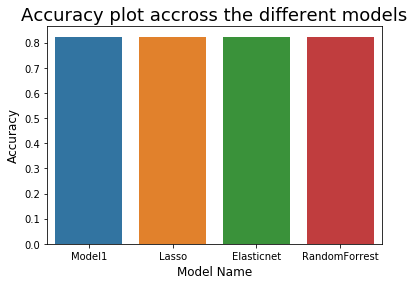

In [60]:
sns.barplot(x=model_names, y=accuracy_arr)
plt.title('Accuracy plot accross the different models', fontsize=18)
plt.xlabel('Model Name', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

#### 6.2.2 Precision Plot

Text(0, 0.5, 'Precision')

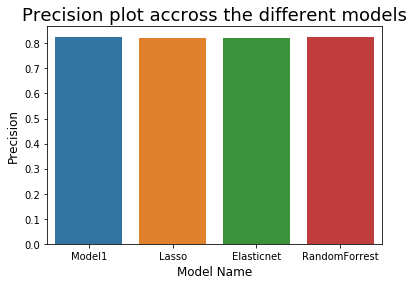

In [61]:
sns.barplot(x=model_names, y=percision_arr)
plt.title('Precision plot accross the different models', fontsize=18)
plt.xlabel('Model Name', fontsize=12)
plt.ylabel('Precision', fontsize=12)

In [62]:
#### 6.2.3 Recall Plot

Text(0, 0.5, 'Recall')

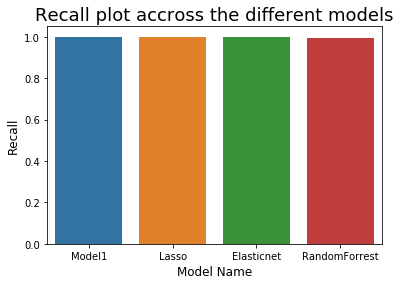

In [63]:
sns.barplot(x=model_names, y=recal_arr)
plt.title('Recall plot accross the different models', fontsize=18)
plt.xlabel('Model Name', fontsize=12)
plt.ylabel('Recall', fontsize=12)

In [64]:
#### 6.2.4 Specificity Plot

Text(0, 0.5, 'Specificity')

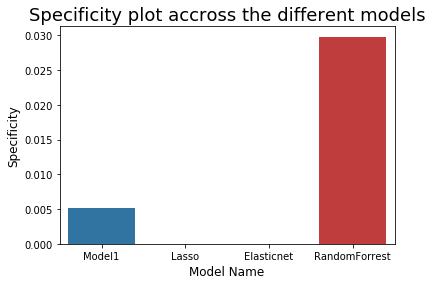

In [65]:
sns.barplot(x=model_names, y=specificity_arr)
plt.title('Specificity plot accross the different models', fontsize=18)
plt.xlabel('Model Name', fontsize=12)
plt.ylabel('Specificity', fontsize=12)

In [66]:
#### 6.2.5 Cost Plot

Text(0, 0.5, 'Cost')

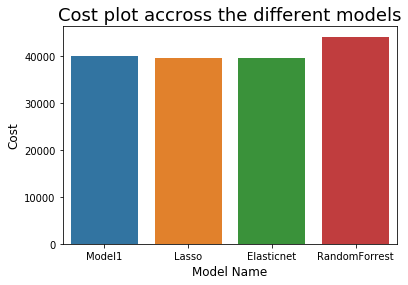

In [67]:
sns.barplot(x=model_names, y=cost_arr)
plt.title('Cost plot accross the different models', fontsize=18)
plt.xlabel('Model Name', fontsize=12)
plt.ylabel('Cost', fontsize=12)

**From the plots above we can see that regarding the accuracy and precision and recall metrics al models are close, but for the specifity metric only the random forrest does better, the cost function has lasso and elasticnets exactly the same and the randomforrest is exceeding but by much** 

### 6.4 Write the conclusion
Write 2-3 paragraphs about what you learn about your model performance and the usefulness of different features.

    There are a lot of things that we learned in this assignement, from the start of to clean the data and do some logic that came basically from understanding the problem and the features evry well, We could save a lot of rows from the drop function by substituting from other related columns! Also we came to the importance of having the datase to be documented as we got most of our feature selection from the dataset as some data cleaning steps! The features that we used are 'States' which gave us a better accuracy when used with tuning data but not much difference with test data but when used with the lasso regressor it took too much time to run! also elasticnet! The other features we used are ['LowDoc', 'is53', 'isRealEstate','sizeOfBusiness', 'isFranchise', 'isExist', 'isDueInGreatRecession','SBA_portion',] and we noticed that removing the Lasso and Elastic net are doing same performance which means that the L2 normalization part is probably turned off, making no difference! 
    We realize now that our models are not doing better than the majority class classifier and it needs more sophisticated feature engineering, also when feeding it to the Lasso model we got the same accuracy which means we need to feed it more features or do more operations and manipulations on features!

Questions:
1. Logistic Regression!
2. Dummy Encoder
3. Onehotencoder.
4. Continous vs Categorical Data.
5. MajorityClass Classifier?
6. Confusion Matrix?
7. Accuracy vs Specifity vs Precision vs Recall ?
8. Which metric to choose for this application?

# The End